In [1]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from utils import load, table_pivot, balanceo_smote, balanceo_total, completar
from itertools import combinations

# serum

In [2]:
df_study = load('./data/regularizacion/dataframe_serum_regularized.csv')

In [3]:
iDSamples = [x for x in enumerate(df_study.Sample)]
df_study.drop('Sample', axis=1, inplace=True)

In [4]:
lista = ['Cancer', 'Desc']
table_pivot(df_study,lista, lista[1], lista[0])

Cancer,False,True
Desc,,
Atypical leiomyoma,0,1
Brenner tumor,0,1
Brenner tumor with mucinous cystadenofibroma,0,1
Clear cell,0,1
Control,6,0
Endo-Clear Cell,0,9
Endometrial Adenocarcinoma,0,2
Endometrioid,0,5
Endometrioma,0,6


In [5]:
print(f'Filtro aquellos tipos de cáncer que se repiten menos de 2 veces')

Filtro aquellos tipos de cáncer que se repiten menos de 2 veces


In [6]:
subclases = [x[0] for x in (df_study.Desc.value_counts()>2).items() if x[1]==True]

df_study = df_study[(df_study.Desc.isin(subclases))].copy()
df_study.reset_index(drop=True, inplace=True)

In [7]:
print(df_study.Cancer.value_counts())

Cancer
True     83
False     6
Name: count, dtype: int64


## Normalizo

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar el escalador MinMax
scaler = MinMaxScaler()

# Normalizar los datos del DataFrame
variables_miR_norm = pd.DataFrame(scaler.fit_transform(df_study.iloc[:,5:]), columns=df_study.iloc[:,5:].columns)

df_study = pd.concat([df_study.iloc[:,:5],variables_miR_norm],axis=1)

df_study.tail(2)

,Sex,Fluid,Cancer,Exosome,Desc,hsa-miR-6850-3p,hsa-miR-4761-3p,hsa-miR-99b-3p,hsa-miR-3129-5p,hsa-miR-6820-5p,...,hsa-miR-2467-3p,hsa-miR-6512-5p,hsa-miR-6718-5p,hsa-miR-520h,hsa-miR-6796-5p,hsa-miR-1245b-5p,hsa-miR-5586-3p,hsa-miR-29a-5p,hsa-miR-1304-3p,hsa-miR-384
87,female,serum,False,False,Control,0.0,1.0,0.089665,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394581,0.0
88,female,serum,True,False,Serous,0.0,0.0,0.834784,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.558107,0.0


## Balanceo datos

In [9]:
lista = ['Sex','Cancer']
table_pivot(df_study, lista, lista[0], lista[1])

Cancer,False,True
Sex,,
female,6,83


In [10]:
lista = ['Sex','Desc']
table_pivot(df_study, lista, lista[0], lista[1])

Desc,Control,Endo-Clear Cell,Endometrioid,Endometrioma,Mucinous,Serous
Sex,,,,,,
female,6,9,5,6,4,59


In [11]:
lista = ['Sex','Desc', 'Exosome']
table_pivot(df_study, lista, lista[0], lista[1:])

Desc,Control,Endo-Clear Cell,Endometrioid,Endometrioma,Mucinous,Serous
Exosome,False,False,False,False,False,False
Sex,,,,,,
female,6,9,5,6,4,59


In [12]:
from itertools import combinations

combinacion = list(combinations(df_study.Desc.unique(),2))
combinacion_se = [comb for comb in combinacion if df_study.Desc.value_counts().idxmax() in comb]
combinacion_se

[('Serous', 'Mucinous'),
 ('Serous', 'Endometrioid'),
 ('Serous', 'Control'),
 ('Serous', 'Endometrioma'),
 ('Serous', 'Endo-Clear Cell')]

In [13]:
df_prueba = df_study.copy()
for sex in df_study.Sex.unique():
    for comb1, comb2 in combinacion_se:
        df1 = df_prueba[(df_prueba.Desc==comb1) | (df_prueba.Desc==comb2)].reset_index(drop=True)
        df1 = df1[df1.Sex==sex].copy()
        #print(comb1,comb2, sex)
        if df1.Desc.nunique()>1:
            try:
                df_minoritario = balanceo_total(df1,'Desc',4)
            except:
                df_minoritario = balanceo_smote(df1,'Desc')
            df_prueba = completar(df_prueba,'Desc', df_minoritario, df1)
        else:
            pass
    df_prueba['Cancer'] = (df_prueba.Cancer).astype(bool)
#df_minoritario=balanceo_smote(df_prueba, 'Cancer')
#df_prueba=completar(df_prueba,'Cancer', df_minoritario, df_prueba)

In [14]:
df_prueba.Desc.value_counts()

Desc
Endo-Clear Cell    61
Mucinous           60
Control            60
Serous             59
Endometrioid       58
Endometrioma       58
Name: count, dtype: int64

In [15]:
lista = ['Sex','Desc']
table_pivot(df_prueba, lista, lista[0], lista[1:])

Desc,Control,Endo-Clear Cell,Endometrioid,Endometrioma,Mucinous,Serous
Sex,,,,,,
female,60,61,58,58,60,59


In [16]:
lista = ['Sex','Desc', 'Exosome']
table_pivot(df_prueba, lista, lista[0], lista[1:])

Desc,Control,Endo-Clear Cell,Endometrioid,Endometrioma,Mucinous,Serous
Exosome,False,False,False,False,False,False
Sex,,,,,,
female,60,61,58,58,60,59


In [17]:
df_study = df_prueba.copy()

In [18]:
df_study.to_csv('./data/Normalizado_serum.csv', index=False)

## Estadísticos

### Homocedasticidad

In [18]:
from utils import Homocedasticity

homoc = Homocedasticity(df_study.iloc[:,5:])

In [19]:
homoc.verify()

Homocedasticidad de las columnas: False


**Distribucion**

In [20]:
import sweetviz as sv

df=df_study.iloc[:,5:56].copy()

# Generar el informe
reporte = sv.analyze(df)

folder = './figures/serum'

# Mostrar el informe en un navegador
reporte.show_html(f'{folder}/Distribucion_report.html')

                                             |                                             | [  0%]   00:00 ->…

Report ./figures/serum/Distribucion_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


from skimpy import skim

skim(df)

**Varianzas**

In [20]:
varianzas = homoc.varianza()

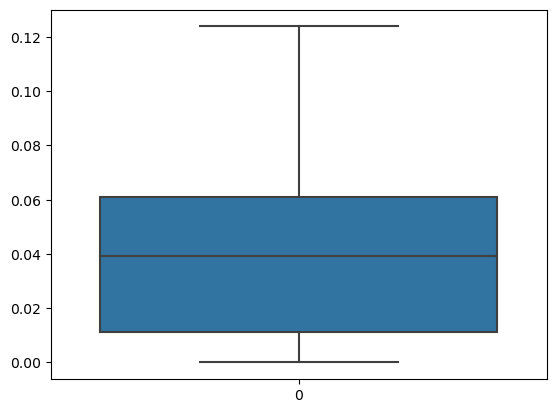

In [21]:
homoc.boxplot()

**Seleccionar varianzas distintas de 0**

In [22]:
df_varianza = homoc.dataframe()

In [23]:
variables = [i for i in df_varianza.columns if df_varianza.loc[0,i]>0]
len(variables)

1763

**Seleccionar varianzas filtradas**

In [24]:
filtroBajo = df_varianza.T.describe().loc['25%',0]
filtroAlto = (df_varianza.T.describe().loc['75%',0] + df_varianza.T.describe().loc['50%',0])/2

variablesAcotadas = [col for col in df_varianza.columns if  filtroAlto > df_varianza.loc[0,col] > filtroBajo]
len(variablesAcotadas)

721

In [25]:
df_study = pd.concat([df_study.iloc[:,:5], df_study.loc[:,variablesAcotadas]], axis=1)

In [26]:
variables = variablesAcotadas

### Kruskal-Wallis

In [27]:
variables.append('Desc')
#varianzas.remove('Desc')
df = df_study[variables].copy()

In [28]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# Separar las características y la variable objetivo
X = df.iloc[:,:-1]
y = df['Desc']

# Lista para almacenar los resultados de las pruebas de Dunn
dunn_results = {}

significant_features = []

# Aplicar la prueba de Kruskal-Wallis a cada característica
p_values = []
for column in X.columns:
    # Obtener las muestras para cada clase
    samples = [X[column][y == cls].values for cls in y.unique()]
    stat, p_value = kruskal(*samples)
    p_values.append((column, p_value))
    
    # Si la prueba de Kruskal-Wallis es significativa (p < 0.05), aplicar la prueba de Dunn
    if p_value < 0.05:
        # Combinar X y y en un DataFrame para la prueba de Dunn
        data = pd.DataFrame({
            'values': X[column],
            'group': y
        })
        
        # Aplicar la prueba de Dunn con ajuste de Bonferroni para comparaciones múltiples
        dunn_result = sp.posthoc_dunn(data, val_col='values', group_col='group', p_adjust='bonferroni')
        
        # Almacenar el resultado de la prueba de Dunn
        dunn_results[column] = dunn_result


# Mostrar los resultados de la prueba de Dunn
for feature, result in dunn_results.items():
    print(f"Prueba de Dunn para la característica: {feature}")
    print(result)

Prueba de Dunn para la característica: hsa-miR-4761-3p
                      Control  Endo-Clear Cell  Endometrioid  Endometrioma  \
Control          1.000000e+00         0.357421  1.766873e-10  1.766873e-10   
Endo-Clear Cell  3.574214e-01         1.000000  7.319736e-05  7.319736e-05   
Endometrioid     1.766873e-10         0.000073  1.000000e+00  1.000000e+00   
Endometrioma     1.766873e-10         0.000073  1.000000e+00  1.000000e+00   
Mucinous         1.178663e-10         0.000061  1.000000e+00  1.000000e+00   
Serous           2.901458e-08         0.002376  1.000000e+00  1.000000e+00   

                     Mucinous        Serous  
Control          1.178663e-10  2.901458e-08  
Endo-Clear Cell  6.056351e-05  2.376349e-03  
Endometrioid     1.000000e+00  1.000000e+00  
Endometrioma     1.000000e+00  1.000000e+00  
Mucinous         1.000000e+00  1.000000e+00  
Serous           1.000000e+00  1.000000e+00  
Prueba de Dunn para la característica: hsa-miR-3129-5p
                     

In [29]:
variablesDunn = []

for clas1 in  df.Desc.unique():
    resultados = {}
    
    listado = df.Desc.unique().tolist()
    listado.remove(clas1)
    
    for clas2 in listado:
        # Inicializar una lista para las dos características con los menores p-values
        resultados[clas2] = [(None, 1), (None, 1), (None, 1)]  # Aquí guardaremos las dos mejores
        
        for x, y in dunn_results.items():
            # Obtener el valor p para las comparaciones entre clas1 y clas2
            valor = y[clas1][clas2]
            
            # Si el p-value es menor que el tercer menor valor actual, lo insertamos en la lista
            if valor < resultados[clas2][2][1]:  # Comparamos con el tercer menor
                # Insertar y ordenar los dos menores p-values
                resultados[clas2].append((x, valor))
                resultados[clas2] = sorted(resultados[clas2], key=lambda z: z[1])[:3]

    print(resultados)
    variablesDunn.extend([x[0][0] for x in resultados.values()])
    variablesDunn.extend([x[1][0] for x in resultados.values()])
    variablesDunn.extend([x[2][0] for x in resultados.values()])
    

{'Mucinous': [('hcmv-miR-US33-5p', 5.0216907535853e-28), ('hsa-miR-3165', 4.223695957649604e-27), ('hsa-miR-6881-3p', 1.543207500824564e-21)], 'Endometrioid': [('hsa-miR-449c-5p', 1.2188484131999795e-26), ('hsa-miR-6715b-3p', 9.07000172784831e-26), ('hsa-miR-4701-5p', 7.795216855013845e-19)], 'Control': [('hsa-miR-23b-3p', 1.59202242295708e-20), ('hsa-miR-1293', 5.0102248446230034e-20), ('hsa-miR-484', 1.7955247637638325e-18)], 'Endometrioma': [('hsa-miR-1193', 5.393808436980067e-23), ('hsa-miR-7151-5p', 2.6674487414356474e-22), ('hsa-miR-7109-3p', 1.6386938203980988e-15)], 'Endo-Clear Cell': [('hsa-miR-4715-5p', 2.1574967502450684e-23), ('hsa-miR-3131', 7.62769246628928e-18), ('hsa-miR-153-3p', 1.483563165888275e-17)]}
{'Serous': [('hcmv-miR-US33-5p', 5.0216907535853e-28), ('hsa-miR-3165', 4.223695957649604e-27), ('hsa-miR-6881-3p', 1.543207500824564e-21)], 'Endometrioid': [('hcmv-miR-US33-5p', 1.4731821470177441e-33), ('hsa-miR-3165', 1.1566409127340133e-32), ('hsa-miR-6881-3p', 1.12

In [30]:
variablesDunn = list(set(variablesDunn))
print(f'VariablesDunn: \n\n{variablesDunn}')
print(f'\nTotal de biomarcadores: {len(variablesDunn)}')

VariablesDunn: 

['hsa-miR-449c-5p', 'hcmv-miR-US33-5p', 'hsa-miR-10a-3p', 'hsa-miR-1293', 'hsa-miR-323b-3p', 'hsa-miR-3165', 'hsa-miR-641', 'hsa-miR-23b-3p', 'hsa-miR-153-3p', 'hsa-miR-1193', 'hsa-miR-340-5p', 'hsa-miR-4715-5p', 'hsa-miR-7109-3p', 'hsa-miR-126-5p', 'hsa-miR-7151-5p', 'hsa-miR-484', 'hsa-miR-337-3p', 'hsa-miR-369-5p', 'hsa-miR-3131', 'hsa-miR-6881-3p', 'hsa-miR-4701-5p', 'hsa-miR-27b-3p', 'hsa-miR-6715b-3p']

Total de biomarcadores: 23


**Modifico dataframe de estudio**

In [31]:
df_study = pd.concat([df_study.iloc[:,:5],df_study[variablesDunn]], axis=1)
df_study.reset_index(drop=True, inplace=True)

## Ordeno variables por p-value en orden descendente

In [32]:
# Separar las características y la variable objetivo
X = df_study.iloc[:,5:]
y = df_study['Desc']

# Aplicar la prueba de Kruskal-Wallis a cada característica
p_values = []
for column in X.columns:
    # Obtener las muestras para cada clase
    samples = [X[column][y == cls].values for cls in y.unique()]
    stat, p_value = kruskal(*samples)
    p_values.append((column, p_value))

In [33]:
p_values_sorted = sorted(p_values, key=lambda x: x[1])
variables_sorted = [x[0] for x in p_values_sorted]

print (f'p_value máximo: {p_values_sorted[-1]}')
print (f'Total de variables: {len(variables_sorted)}')

p_value máximo: ('hsa-miR-7109-3p', 5.308214608288803e-23)
Total de variables: 23


**Guardo dataframe**

In [34]:
df_study = pd.concat([df_study.iloc[:,:5],df_study[variables_sorted]],axis=1)
df_study.to_csv('./data/Cluster_serum.csv', index=False)

### Prueba U Mann entre matrices de cancer y sin cancer

In [35]:
combinaciones = list(combinations(df_conjunto.Desc.unique(),2))
combinaciones

[('Healthy Control', 'Colorectal Cancer'),
 ('Healthy Control', 'Prostate Cancer'),
 ('Healthy Control', 'Pancreatic Cancer'),
 ('Healthy Control', 'Metastatic renal cell carcinoma (mRCC)'),
 ('Healthy Control', 'chronic fatigue syndrome'),
 ('Healthy Control', 'non-fatigued'),
 ('Colorectal Cancer', 'Prostate Cancer'),
 ('Colorectal Cancer', 'Pancreatic Cancer'),
 ('Colorectal Cancer', 'Metastatic renal cell carcinoma (mRCC)'),
 ('Colorectal Cancer', 'chronic fatigue syndrome'),
 ('Colorectal Cancer', 'non-fatigued'),
 ('Prostate Cancer', 'Pancreatic Cancer'),
 ('Prostate Cancer', 'Metastatic renal cell carcinoma (mRCC)'),
 ('Prostate Cancer', 'chronic fatigue syndrome'),
 ('Prostate Cancer', 'non-fatigued'),
 ('Pancreatic Cancer', 'Metastatic renal cell carcinoma (mRCC)'),
 ('Pancreatic Cancer', 'chronic fatigue syndrome'),
 ('Pancreatic Cancer', 'non-fatigued'),
 ('Metastatic renal cell carcinoma (mRCC)', 'chronic fatigue syndrome'),
 ('Metastatic renal cell carcinoma (mRCC)', 'non-

In [36]:
from scipy.stats import mannwhitneyu

def u_mann(x, y, valor):
    grupo_1 = df_conjunto[df_conjunto.Desc==x].iloc[:,6:]
    grupo_2 = df_conjunto[df_conjunto.Desc==y].iloc[:,6:]
    u_man=[]
    for x in grupo_1.columns:
        stat, p_value = mannwhitneyu(grupo_1[x], grupo_2[x])
    
        u_man.append((x,p_value))
    u_man_sorted = sorted(u_man, key=lambda x: x[1])
    u_man_filter = [x for x in u_man_sorted if x[1]<valor]
    columnas_filtradas = [x[0] for x in u_man_filter]
    return columnas_filtradas

In [37]:
frecuencia = {}
for feature in df_conjunto.iloc[:,6:].columns.tolist():
    frecuencia[feature] = 0

for comb in combinaciones:
    columnas_filtradas = u_mann(comb[0],comb[1],5.e-3)
    for variable in columnas_filtradas:
        frecuencia[variable] += 1

In [39]:
frecuencia_sort = sorted(frecuencia.items(), key=lambda x: x[1], reverse=True)
columnas_filtradas = [x[0] for x in frecuencia_sort if x[1]>int(len(combinacion)*0.80)]
print(len(columnas_filtradas))

32


#### Guardo df_cluster

In [40]:
df_cluster = df_conjunto.loc[:, df_conjunto.iloc[:,:6].columns.tolist() + columnas_filtradas]
df_cluster.reset_index(drop=True, inplace=True)

In [41]:
df_cluster.to_csv('./data/Cluster_plasma.csv', index=False)

### Clustermap

In [2]:
df_cluster= load('./data/Cluster_serum.csv')

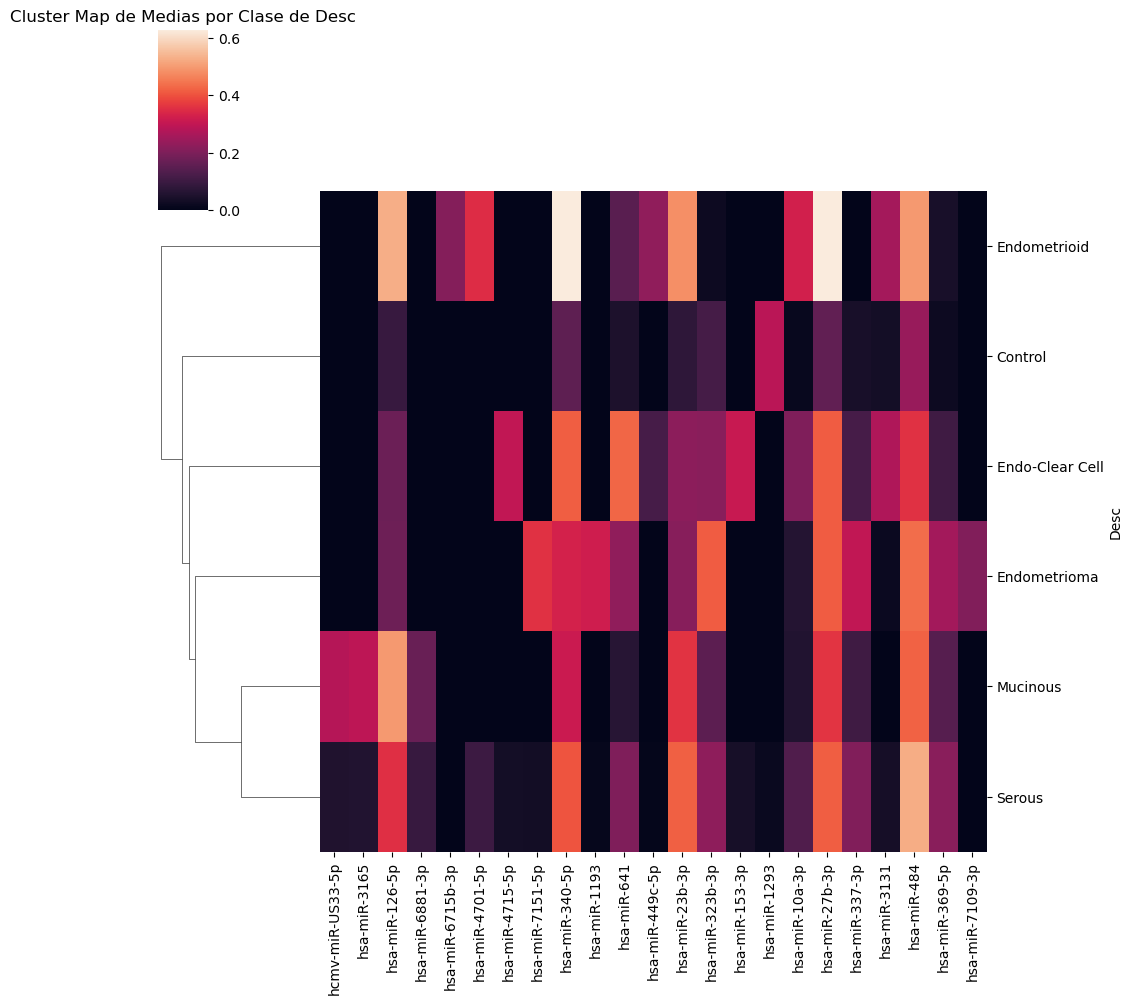

In [3]:
# Definir la subcarpeta de figuras
subcarpeta_figuras = 'figures/serum'
os.makedirs(subcarpeta_figuras, exist_ok=True)

# Filtrar las clases únicas en 'Desc'
clases = df_cluster.Desc.unique()

# Calcular la media de cada variable para cada clase de 'Desc'
df_means = df_cluster.iloc[:,4:].groupby('Desc').mean()

# Crear un clustermap basado en las medias por clase, sin la barra de colores superior
sns.clustermap(df_means, col_cluster=False, cbar_kws={"orientation": "vertical"}, row_cluster=True)

# Configurar el título
plt.title('Cluster Map de Medias por Clase de Desc')

# Guardar y mostrar el gráfico
plt.savefig(f'./{subcarpeta_figuras}/clustermap_means.png', bbox_inches='tight')
plt.show()

Serous


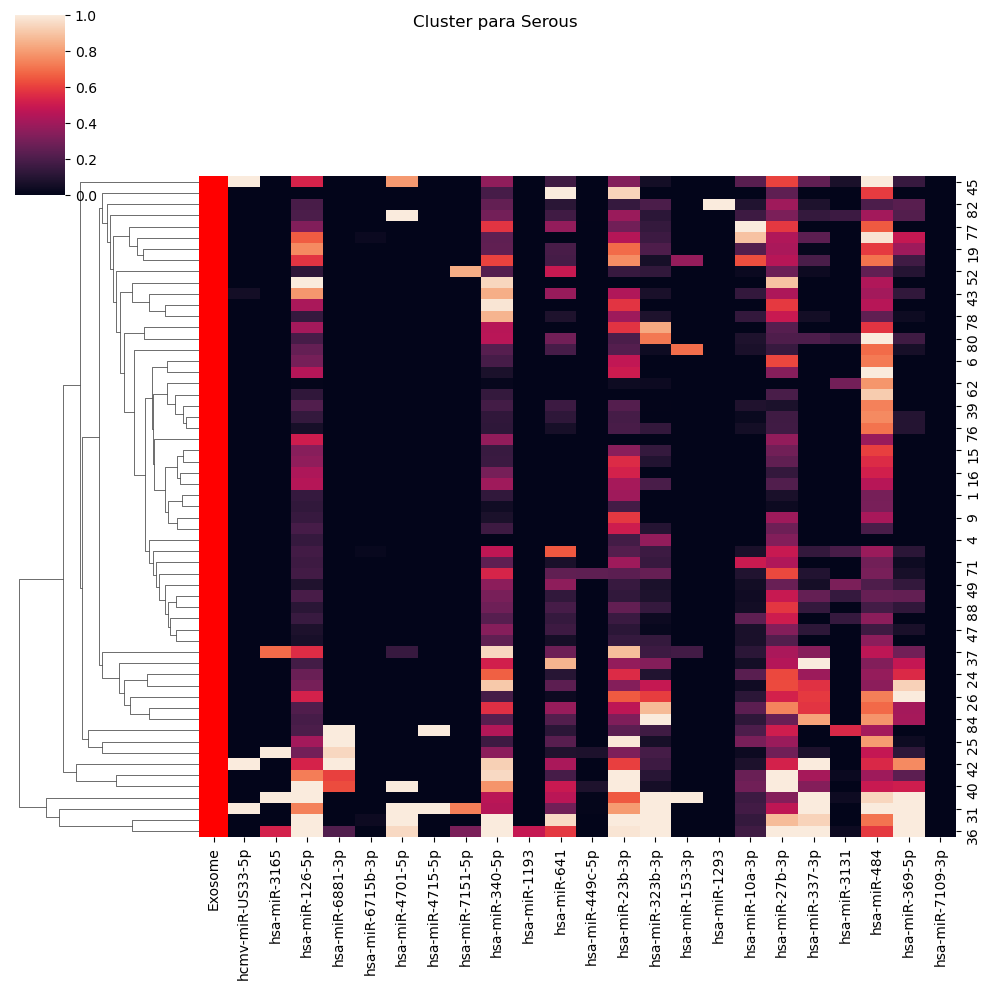

Mucinous


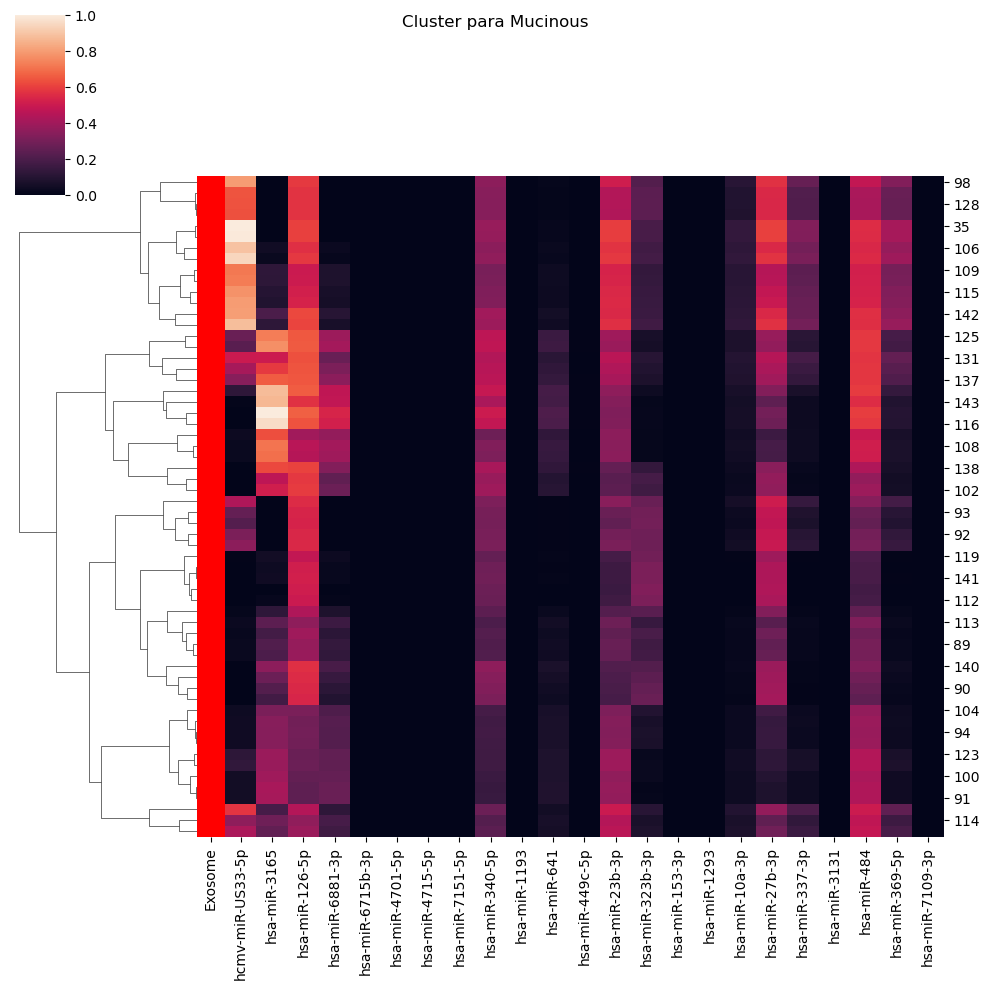

Endometrioid


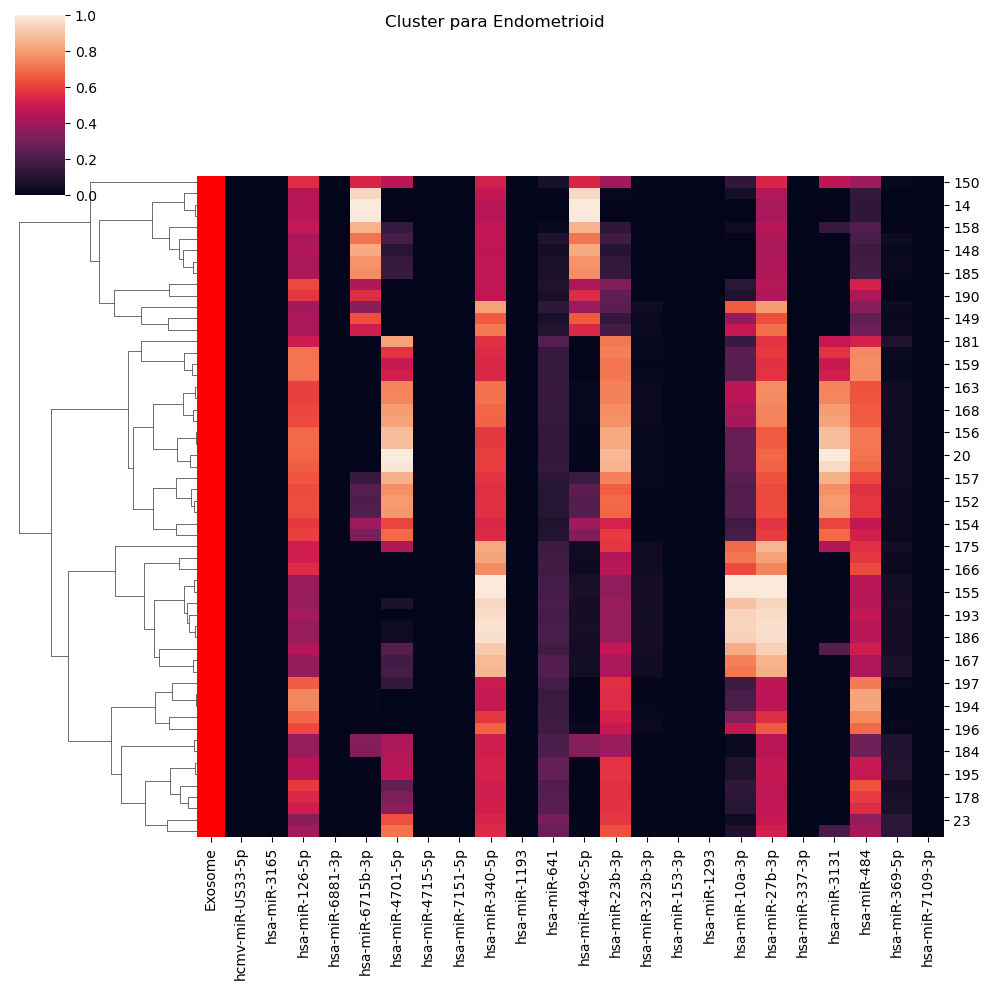

Control


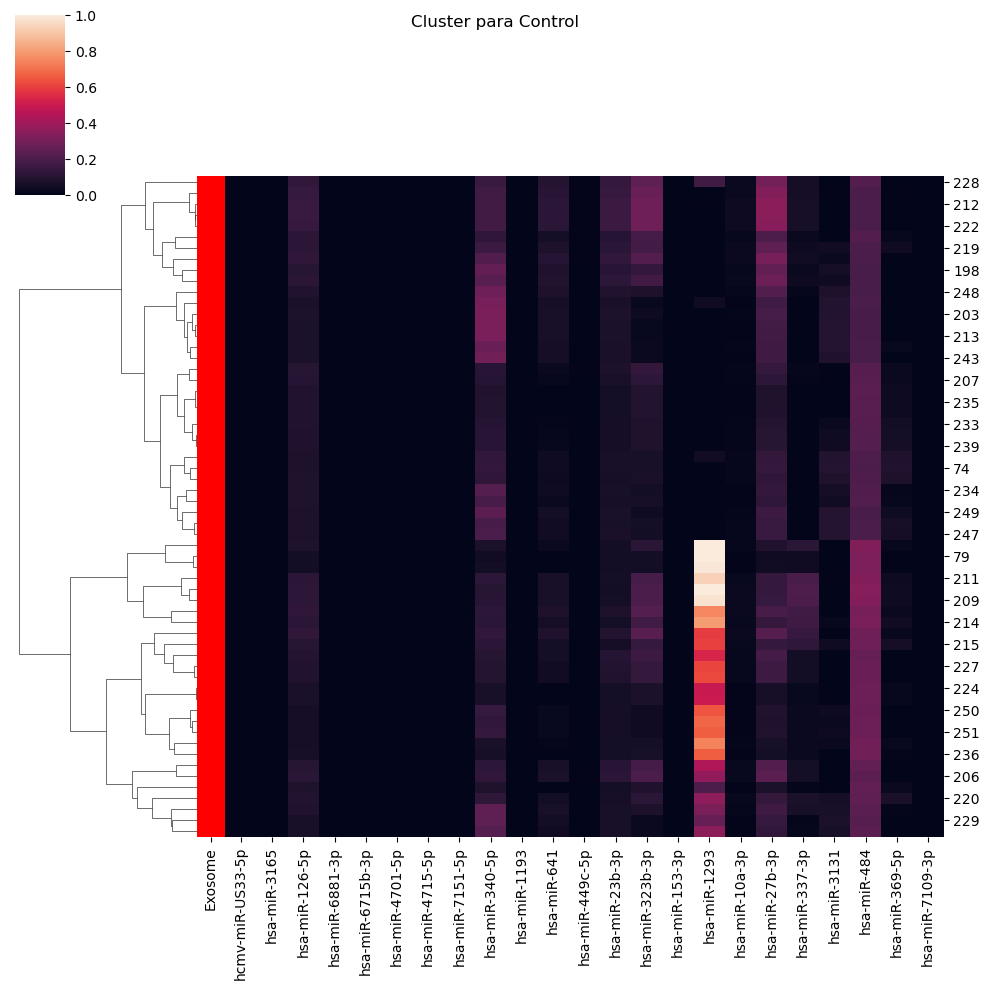

Endometrioma


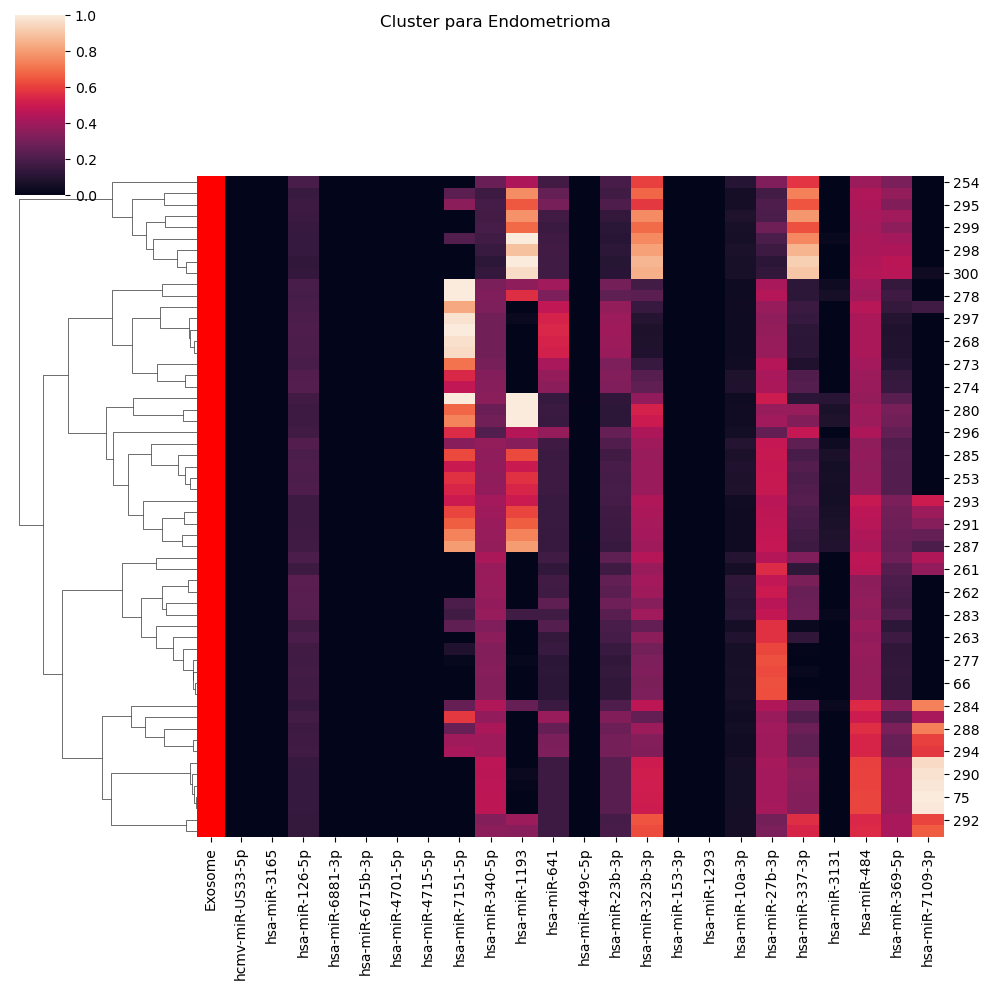

Endo-Clear Cell


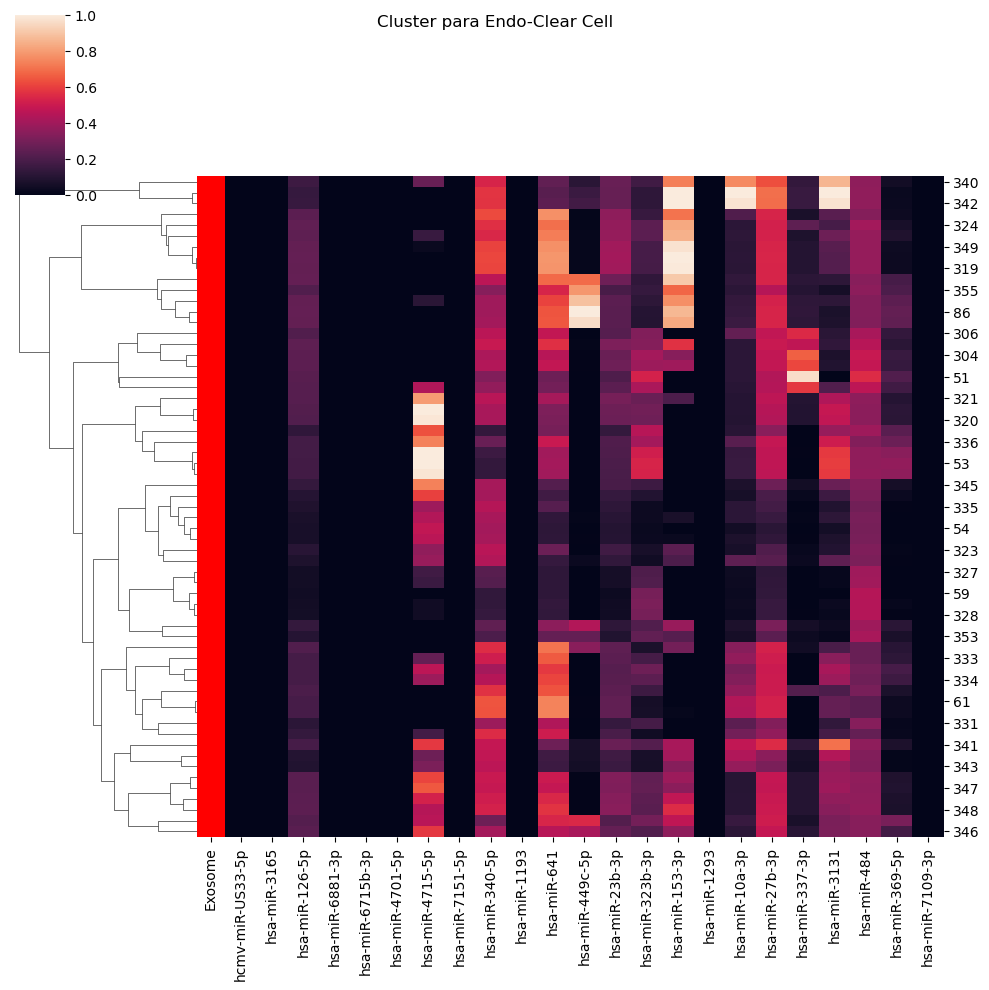

In [36]:
#Subcarpeta modelo
subcarpeta_figuras='figures/serum'

if os.path.exists(subcarpeta_figuras):
    pass
else:
    os.mkdir(subcarpeta_figuras)

# Filtrar las clases únicas en 'Desc'
clases = df_cluster.Desc.unique()

for i, clas in enumerate(clases):
    print(clas)
    df_filter = df_cluster[df_cluster.Desc == clas].copy()

    exo_palette = {True: 'blue', False: 'red'}
    row_colors = df_filter['Exosome'].map(exo_palette)

    # Crear un clustermap para cada clase (no se puede usar `ax`)
    sns.clustermap(df_filter[variables_sorted], col_cluster=False, cbar_kws={"orientation": "vertical"}, row_cluster=True, row_colors=row_colors)
    #sns.clustermap(df_filter[variables], col_cluster=False, cbar_kws={"orientation": "vertical"}, row_cluster=True, row_colors=row_colors)
    
    # Configurar el título
    plt.suptitle(f'Cluster para {clas}')
    plt.savefig(f'./{subcarpeta_figuras}/clustermap_{clas}.png', bbox_inches='tight')
    
    # Mostrar el gráfico
    plt.show()



## Distribucion 

C:\Users\eagle\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


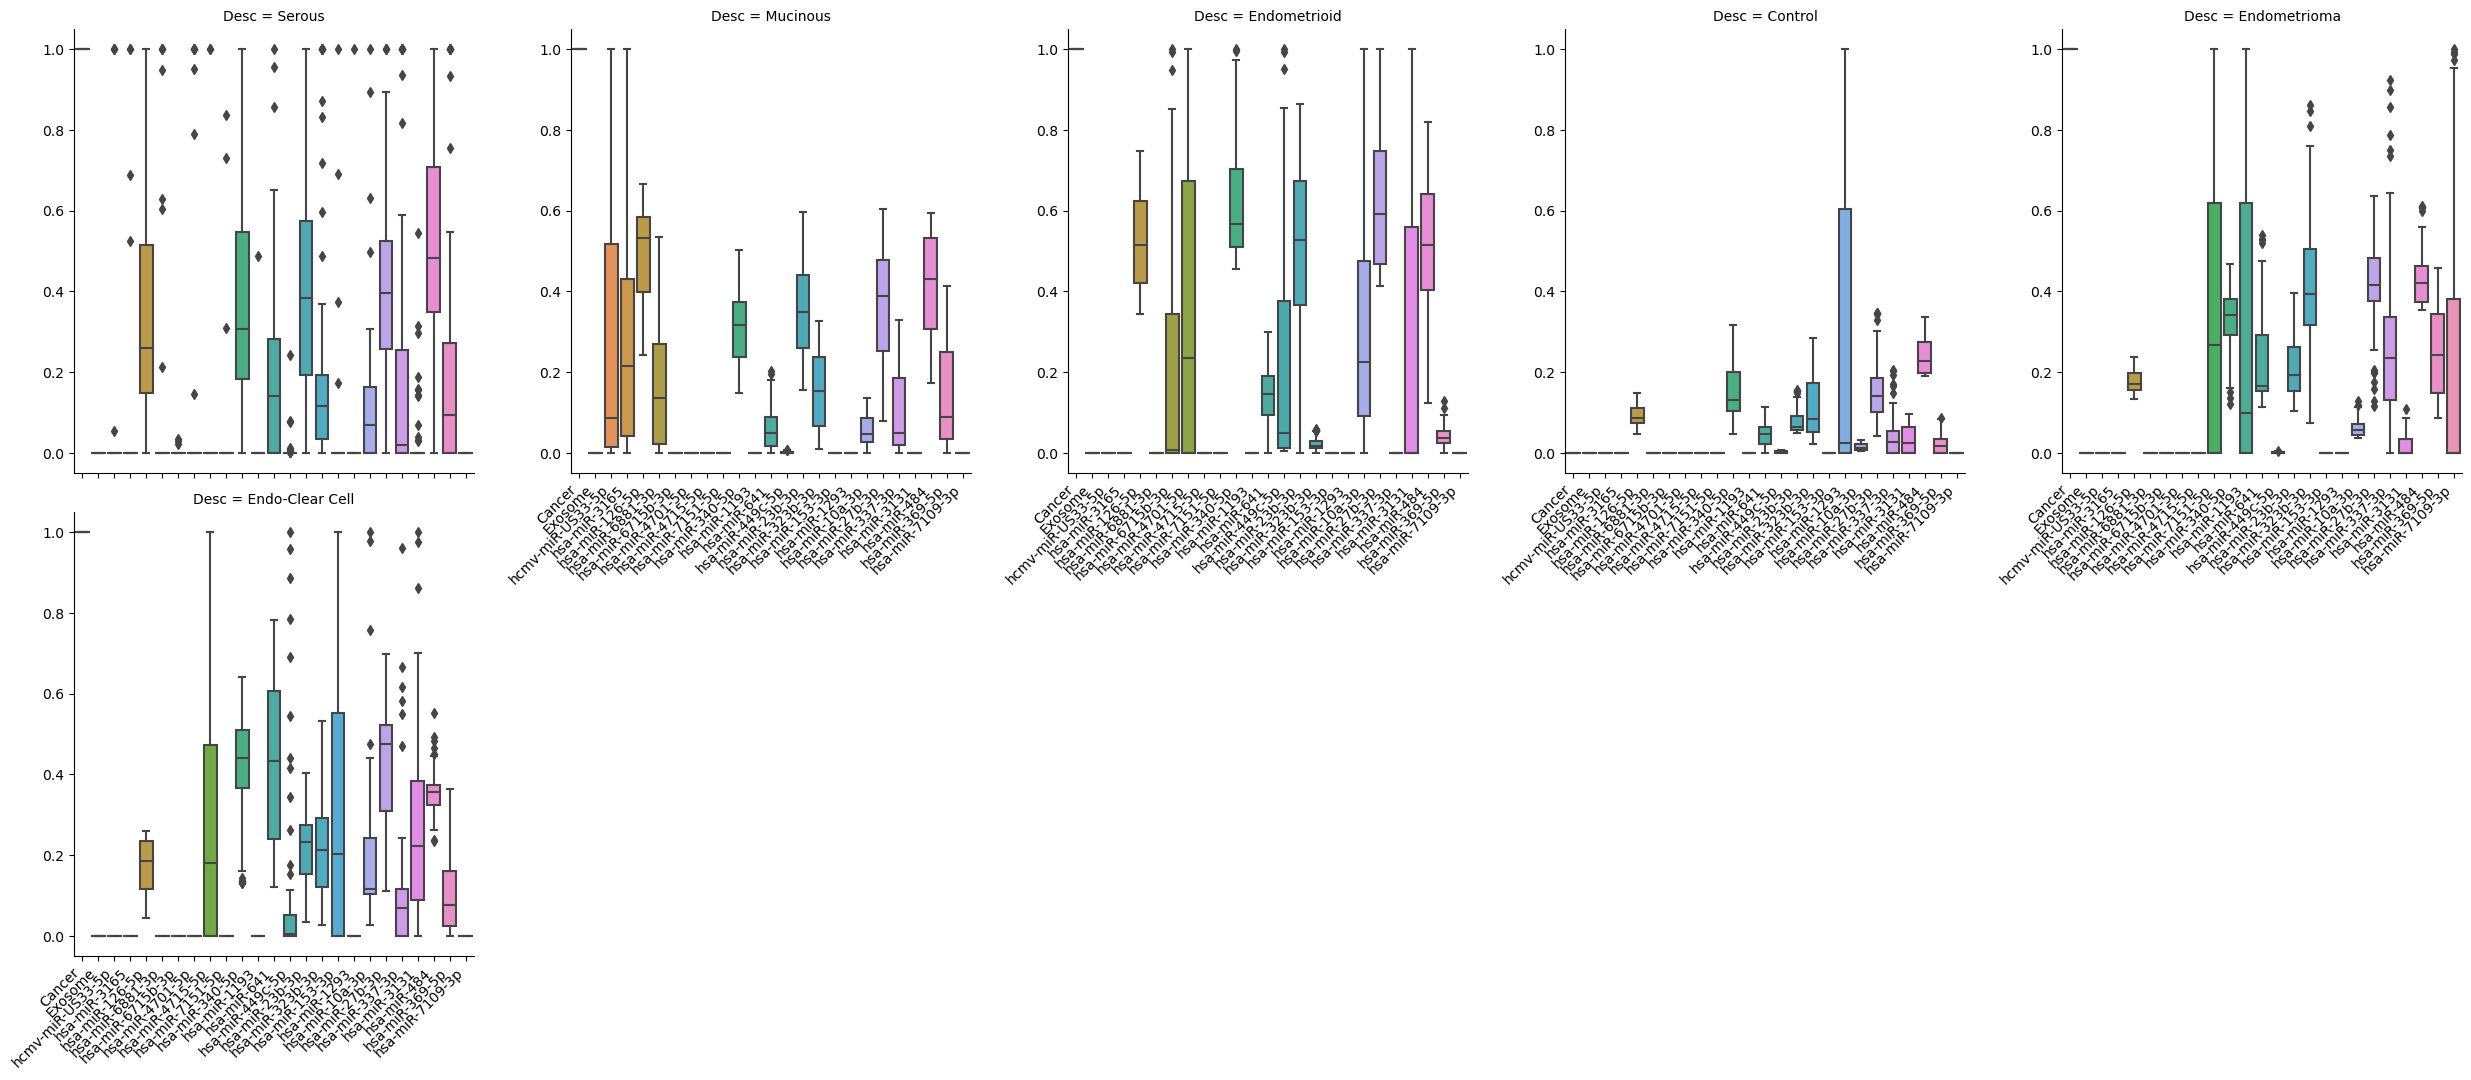

In [37]:
g = sns.catplot(df_study, kind='box',col='Desc',col_wrap=5, orient='v', sharey=False)

# Rotar etiquetas del eje x
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')  # Opcional: para alinear mejor las etiquetas

    
plt.savefig(f'./figures/serum/boxplot_variables.png', bbox_inches='tight')
plt.show()

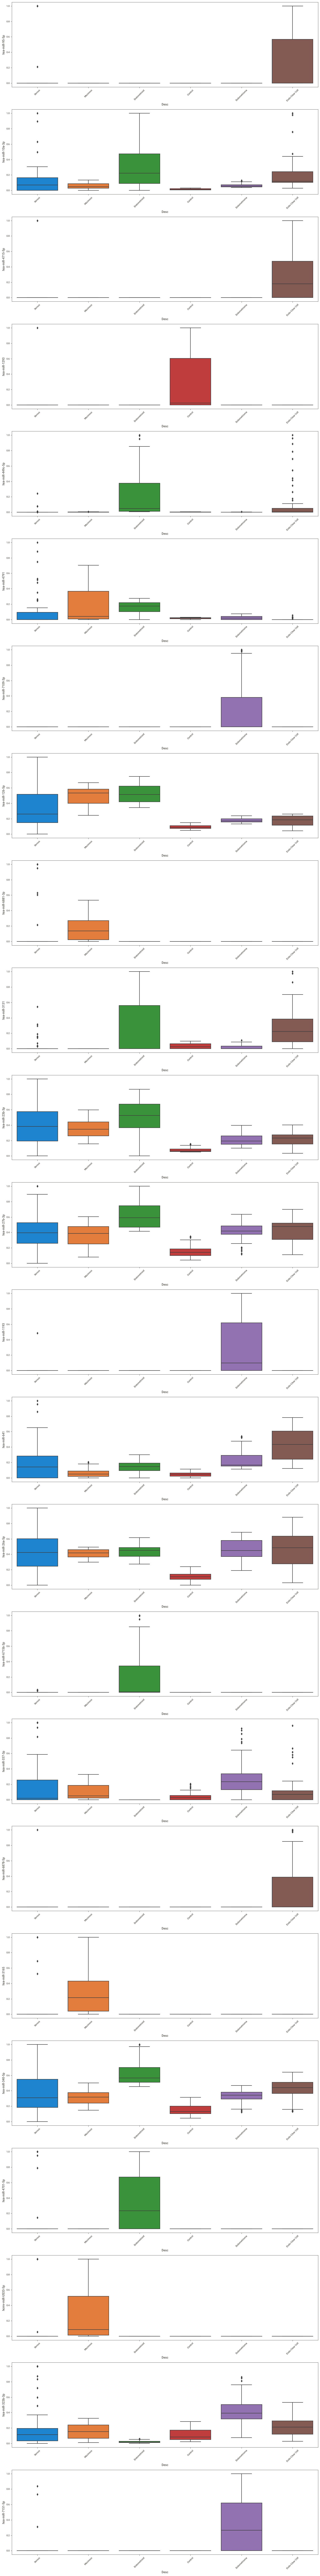

In [45]:
# Filtramos las columnas que contienen los valores de microARN
microRNA_columns = df_study.columns[5:]  # Ajustar según las columnas de tu dataframe

# Crear una figura con subplots
fig, axes = plt.subplots(len(microRNA_columns), figsize=(15, len(microRNA_columns) * 5), sharey=True)

# Iterar sobre cada valor único de 'Sex' y cada microRNA
for i, feature in enumerate(microRNA_columns):
    sns.boxplot(x='Desc', y=feature, data=df_study, ax=axes[i])
    axes[i].set_xlabel('Desc')
    axes[i].set_ylabel(feature)

    # Rotar las etiquetas del eje x 45 grados
    axes[i].tick_params(axis='x', rotation=45)
     
# Ajustar el layout para que no haya superposición
plt.tight_layout()
plt.savefig(f'./figures/serum/boxplot_Desc.png', bbox_inches='tight')
plt.show()